In [1]:
import os
import random
import shutil
import numpy as np
import cv2
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from tqdm import tqdm
import albumentations as A
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image 
from torchmetrics.detection.mean_ap import MeanAveragePrecision
import copy

cv2.setNumThreads(0)

### Подготовка данных

In [2]:
def set_seed(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)


def convert_yolo_to_pascal_voc(yolo_label_path, image_path, output_label_path):
    """
    Конвертирует один файл аннотации из формата YOLO в PASCAL VOC
    """
    with Image.open(image_path) as img:
        img_width, img_height = img.size

    with open(yolo_label_path, 'r') as f_in, open(output_label_path, 'w') as f_out:
        for line in f_in.readlines():
            parts = line.strip().split()
            if len(parts) != 5:
                continue

            class_id, x_center, y_center, width, height = map(float, parts)

            # 1. Увеличиваем ID класса на 1
            new_class_id = int(class_id) + 1

            # 2. Конвертируем координаты
            abs_width = width * img_width
            abs_height = height * img_height
            abs_x_center = x_center * img_width
            abs_y_center = y_center * img_height

            xmin = int(abs_x_center - (abs_width / 2))
            ymin = int(abs_y_center - (abs_height / 2))
            xmax = int(abs_x_center + (abs_width / 2))
            ymax = int(abs_y_center + (abs_height / 2))

            # Записываем в новом формате
            f_out.write(f"{new_class_id} {xmin} {ymin} {xmax} {ymax}\n")
            

def prepare_pascal_voc_style_dataset(
    original_data_dir,
    yolo_labels_dir, 
    output_base_dir,
    validation_split=0.2,
    random_seed=42
):
    """
    Подготавливает структуру датасета для моделей типа Faster R-CNN.
    Аннотации конвертируются в формат: <class_id+1> <xmin> <ymin> <xmax> <ymax>.

    Args:
        original_data_dir (str): Путь к директории, содержащей все изображения.
        yolo_labels_dir (str): Путь к директории, содержащей исходные YOLO (.txt) аннотации.
        output_base_dir (str): Корневая директория, где будет создан датасет.
        validation_split (float): Доля данных, которая будет использоваться для валидации.
        random_seed (int): Целое число для фиксации случайности.
    """
    set_seed(random_seed)

    print(f"Начинается подготовка датасета в формате PASCAL VOC в '{output_base_dir}'...")
    print(f"Используется random_seed = {random_seed} для воспроизводимости.")

    # Определяем целевые папки
    images_train_dir = os.path.join(output_base_dir, 'images', 'train')
    images_val_dir = os.path.join(output_base_dir, 'images', 'val')
    labels_train_dir = os.path.join(output_base_dir, 'labels', 'train')
    labels_val_dir = os.path.join(output_base_dir, 'labels', 'val')

    # Создаем все необходимые директории
    os.makedirs(images_train_dir, exist_ok=True)
    os.makedirs(images_val_dir, exist_ok=True)
    os.makedirs(labels_train_dir, exist_ok=True)
    os.makedirs(labels_val_dir, exist_ok=True)

    # Собираем список всех изображений и их соответствующих YOLO-аннотаций
    data_files = []
    supported_image_extensions = ('.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.webp')

    print("Собираем список файлов...")
    for filename in tqdm(os.listdir(original_data_dir)):
        if filename.lower().endswith(supported_image_extensions):
            base_name = os.path.splitext(filename)[0]
            image_path = os.path.join(original_data_dir, filename)
            label_path = os.path.join(yolo_labels_dir, f"{base_name}.txt")

            if os.path.exists(label_path):
                data_files.append((image_path, label_path))
            else:
                print(f"Предупреждение: Для изображения '{filename}' не найдена аннотация. Пропускаем.")

    if not data_files:
        print("Ошибка: Не найдено ни одного изображения с соответствующей аннотацией.")
        return

    print(f"Найдено {len(data_files)} пар изображение-аннотация.")

    # Разделяем данные на train и val
    train_files, val_files = train_test_split(data_files, test_size=validation_split, random_state=random_seed)
    print(f"Разделение: {len(train_files)} для обучения, {len(val_files)} для валидации.")

    for image_path, label_path in tqdm(train_files, desc="Обработка train"):
        shutil.copy(image_path, os.path.join(images_train_dir, os.path.basename(image_path)))
        # Конвертируем и сохраняем аннотацию
        output_label_path = os.path.join(labels_train_dir, os.path.basename(label_path))
        convert_yolo_to_pascal_voc(label_path, image_path, output_label_path)

    print("Копируем изображения и конвертируем валидационные аннотации...")
    for image_path, label_path in tqdm(val_files, desc="Обработка val"):
        # Копируем изображение как есть
        shutil.copy(image_path, os.path.join(images_val_dir, os.path.basename(image_path)))
        # Конвертируем и сохраняем аннотацию
        output_label_path = os.path.join(labels_val_dir, os.path.basename(label_path))
        convert_yolo_to_pascal_voc(label_path, image_path, output_label_path)
        
    print(f"\nДанные сохранены в '{output_base_dir}'.")


ORIGINAL_DATA_FOLDER = '/kaggle/input/road-damage-dataset-yolo2/road_damage_dataset_yolo2'
YOLO_LABELS_FOLDER = ORIGINAL_DATA_FOLDER
OUTPUT_DATASET_FOLDER = '/kaggle/working/dataset'

prepare_pascal_voc_style_dataset(
    original_data_dir=ORIGINAL_DATA_FOLDER,
    yolo_labels_dir=YOLO_LABELS_FOLDER,
    output_base_dir=OUTPUT_DATASET_FOLDER,
    validation_split=0.1,
    random_seed=42 
)

Начинается подготовка датасета в формате PASCAL VOC в '/kaggle/working/dataset'...
Используется random_seed = 42 для воспроизводимости.
Собираем список файлов...


100%|██████████| 12250/12250 [00:20<00:00, 603.17it/s]


Найдено 6125 пар изображение-аннотация.
Разделение: 5512 для обучения, 613 для валидации.


Обработка train: 100%|██████████| 5512/5512 [02:30<00:00, 36.53it/s]


Копируем изображения и конвертируем валидационные аннотации...


Обработка val: 100%|██████████| 613/613 [00:16<00:00, 37.11it/s]


Данные сохранены в '/kaggle/working/dataset'.


### Функция для добавления ограничивающих прямоугольников на изображение

In [3]:
def bbox(box, label="", color="red", ax=None):
    x = [box[0], box[0], box[2], box[2], box[0]]
    y = [box[1], box[3], box[3], box[1], box[1]]
    if ax:
        draw_obj = ax
    else:
        draw_obj = plt    
    draw_obj.plot(x, y, color=color, linewidth=1)     
    draw_obj.text(box[0] + 2, box[1], label, fontsize=10, color=color, 
                  verticalalignment='bottom', horizontalalignment='left')

### Классы, которые участвуют в обучении:

- **Класс 1: pothole - выбоина** $\newline$
- **Класс 2: crocodile cracking - крокодиловое растрескивание** $\newline$
- **Класс 3: lateral cracking - трещина в виде линии вдоль всей ширины дороги** $\newline$
- **Класс 4: longitudinal cracking - трещина вдоль линни дороги** $\newline$
- **Класс 5: sewer manhole - канализационный люк**

# Класс датасета 

In [4]:
class RoadDamageDataset(Dataset):
    def __init__(self, url, transforms, is_train=True):
        """
                url: путь к папке с датасетом
            'image': путь к файлу изображения 
            'boxes': список боксов в формате [[xmin, ymin, xmax, ymax], ...]
           'labels': список меток в формате [[1, 3], [2], [4] ...]
         transforms: преобразования для изображения (например, преобразование в тензор)
        """
        self.url = url
        self.transforms = transforms
        self.annotations = []
        images_path = os.path.join(url, "images", "train" if is_train else "val")
        labels_path = os.path.join(url, "labels", "train" if is_train else "val")
        
        for img_name in os.listdir(images_path):
            image_path = os.path.join(images_path, img_name)
            label_name = img_name.split(".")[0] + ".txt" 
            label_path = os.path.join(labels_path, label_name)
            data = open(label_path).read().split()
            bboxs = [int(value) for i, value in enumerate(data) if i % 5]
            labels = [int(value) for i, value in enumerate(data) if not i % 5]
            bbox_coords = []
            for i in range(len(bboxs) // 4):
                box = bboxs[i*4:(i+1)*4]
                bbox_coords.append(box)
            
            d = {"image": image_path, "boxes": bbox_coords, "labels": labels}
            self.annotations.append(d)    
    
    def __getitem__(self, idx):
        annotations = self.annotations[idx]
        image_path = annotations['image']
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        transformed = self.transforms(image=image, bboxes=annotations["boxes"], class_labels=annotations["labels"])
            
        image = transformed['image']
        boxes = torch.tensor(transformed['bboxes'], dtype=torch.float32)
        labels = torch.tensor(transformed['class_labels'], dtype=torch.int64)
        
        target = {
                    "boxes": boxes if len(boxes) else torch.zeros(0, 4),      # Ограничивающие рамки
                    "labels": labels,                                         # Метки классов
                    "image_id": torch.tensor([idx]),                          # Уникальный идентификатор изображения
                    "area": (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) if len(boxes) else torch.tensor([]),
                    "iscrowd": torch.zeros((boxes.shape[0],), dtype=torch.int64)
                 }
        
        return image, target

    def __len__(self):
        return len(self.annotations)

# Аугментации для тренировочной и валидационной выборок

In [5]:
train_transforms = A.Compose(
    [
        A.BBoxSafeRandomCrop(erosion_rate=0.0, p=0.25),
        A.HorizontalFlip(p=0.5),
        A.ConstrainedCoarseDropout(num_holes_range=(2, 4), hole_height_range=(0.05, 0.2), 
            hole_width_range=(0.05, 0.2), bbox_labels=[1, 2, 3, 4, 5], p=0.2),
        A.Affine(scale=(0.9, 1.1), translate_percent=(-0.05, 0.05), rotate=(-8, 8), 
            shear=(-5, 5), balanced_scale=True, border_mode=cv2.BORDER_REPLICATE, p=0.4),
        A.OneOf([
            A.Perspective(scale=(0.01, 0.05), keep_size=True, fit_output=True, 
                border_mode=cv2.BORDER_REPLICATE, p=1),
            A.ElasticTransform(alpha=50, sigma=10, same_dxdy=False, p=1),   
            A.GridDistortion(num_steps=5, distort_limit=(-0.3, 0.3),
                normalized=True, p=1),
            A.GridElasticDeform(num_grid_xy=(5, 5), magnitude=10, p=0.8),
            A.ThinPlateSpline(scale_range=(0.03, 0.1),
                num_control_points=3, p=1),
        ], p=0.2),
        A.OneOf([
            A.AdditiveNoise(noise_type="gaussian", spatial_mode="shared", 
                noise_params={"mean_range": [0, 0], "std_range": [0.01, 0.02]}, p=1),
            A.ISONoise(color_shift=(0.01, 0.05), intensity = (0.1, 0.2), p=1)
        ], p=0.2),
        A.CLAHE(clip_limit=(1, 2), p=0.3),
        A.OneOf([
            A.OneOf([
                A.Blur(blur_limit=(3, 3), p=1),
                A.MotionBlur(blur_limit=(3, 5), allow_shifted=True, p=1),
                A.MedianBlur(blur_limit=(3, 5), p=1)
            ], p=1),
            A.OneOf([
                A.ImageCompression(compression_type='jpeg', 
                    quality_range=(40, 70), p=1),
                A.Downscale(scale_range=(0.5, 0.7), 
                    interpolation_pair={'upscale': 0, 'downscale': 0}, p=1)
            ], p=1),
        ], p=0.15),
        A.OneOf([
            A.PlanckianJitter(mode='blackbody', temperature_limit=(6000, 10000),
                sampling_method='uniform', p=1),
            A.ColorJitter(brightness=(0.9, 1.1), contrast=(0.9, 1.1), 
                saturation=(0.9, 1.1), hue=(-0.1, 0.1), p=1)
        ], p=0.5),
        A.OneOf([
            A.RandomRain(slant_range=(-15, 15), drop_length=10, drop_width=1, 
                drop_color=(200, 200, 200), blur_value=7, brightness_coefficient=0.8, 
                rain_type='default', p=1),
            A.OneOf([
                A.Spatter(gauss_sigma=(4, 6), mode="mud", p=1),
                A.Spatter(gauss_sigma=(4, 6), mode="rain", p=1)
            ], p=1)
        ], p=0.2),
        A.Sharpen(alpha=(0, 0.25), p=0.25),
        A.Resize(800, 1600, interpolation=cv2.INTER_LANCZOS4, p=1.0),
        A.Normalize(),
        #A.ToFloat(max_value=255),
        A.ToTensorV2()
    ], 
    bbox_params=A.BboxParams(
        format='pascal_voc', 
        label_fields=['class_labels'],
        min_area=1.0,       
        min_width=1.0,      
        min_height=1.0  
    )
)

In [6]:
test_transforms = A.Compose([
    A.Resize(800, 1600, interpolation=cv2.INTER_LANCZOS4, p=1.0),
    A.Normalize(),
    #A.ToFloat(max_value=255),
    A.ToTensorV2()], 
    bbox_params=A.BboxParams(
        format='pascal_voc', 
        label_fields=['class_labels'],
        min_area=1.0,       
        min_width=1.0,      
        min_height=1.0,
        min_visibility=0.5 
    )
)

In [7]:
train_dataset = RoadDamageDataset(OUTPUT_DATASET_FOLDER, train_transforms, is_train=True)
test_dataset = RoadDamageDataset(OUTPUT_DATASET_FOLDER, test_transforms, is_train=False)

In [8]:
len(train_dataset), len(test_dataset)

(5512, 613)

In [9]:
def plot_images(indx, dataset, figsize=(25, 28)):
    plt.figure(figsize=figsize)

    for i, img_indx in enumerate(indx):
        plt.subplot(len(indx) // 2, 2, i+1)
        plt.title(f"Изображение {i+1}")
        plt.xticks([]), plt.yticks([])
        img_tensor, target = dataset[img_indx]
        plt.imshow(img_tensor.permute(1, 2, 0))
        for label, box in zip(target["labels"], target["boxes"]):
            bbox(box, label.item())

# Тренировочные примеры (с аугментациями) изображении и их ограничивающие прямоугольники

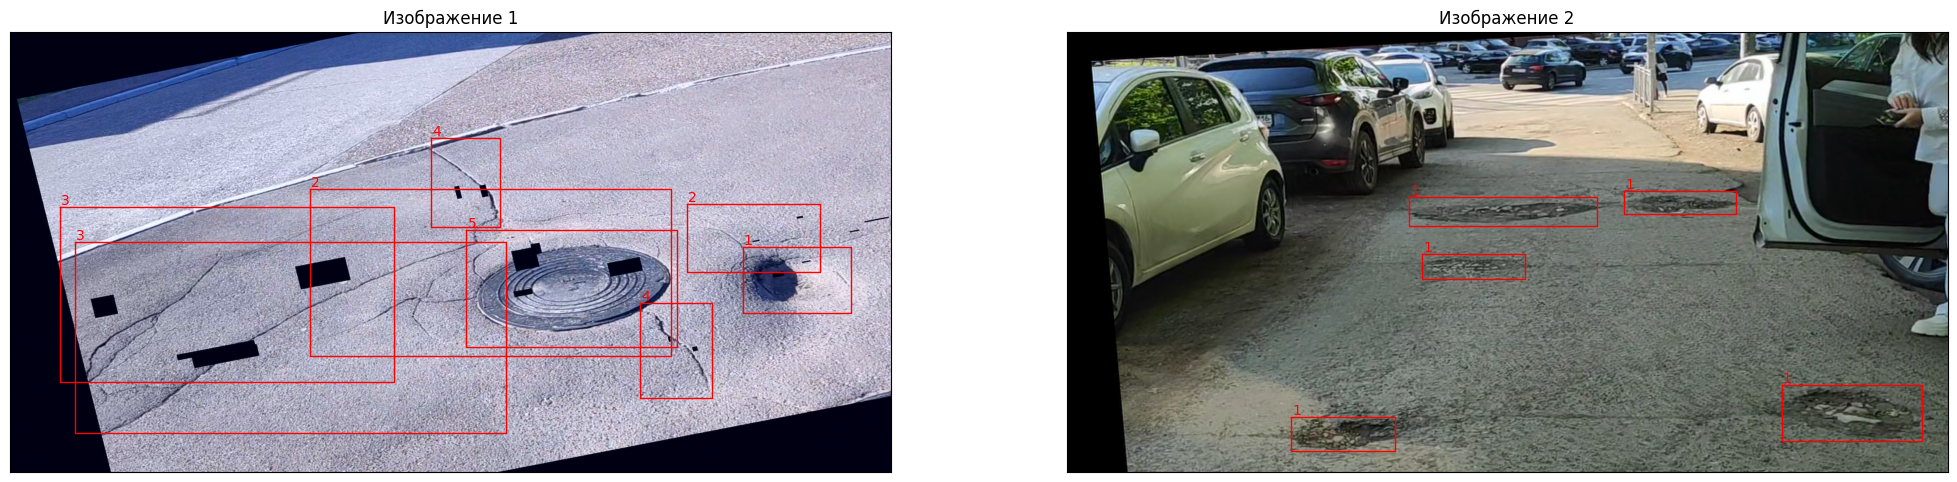

In [88]:
indx = [139, 186]
plot_images(indx, train_dataset)

# Валидационные примеры (без аугментации) изображении и их ограничивающие прямоугольники

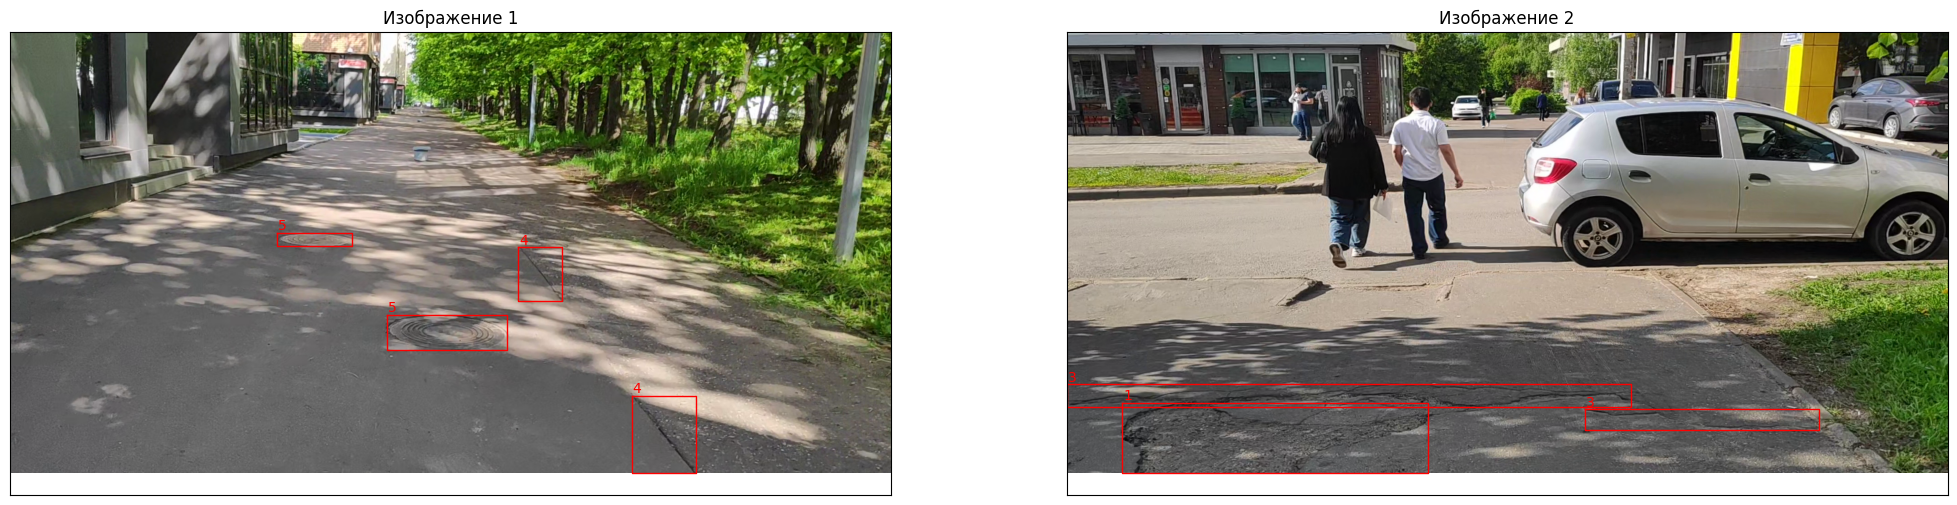

In [89]:
indx = [120, 226]
plot_images(indx, test_dataset, figsize=(25, 35))

In [10]:
def collate_fn(batch):           # Faster R-CNN модель ожидает на вход список словарей
    return tuple(zip(*batch))    # Без этого DataLoader будет "склеивать" элементы в один большой тензор
                                 # batch - List[Tuple(img, dict)] -> zip(*batch) -> ((img1, img2 ...), (dict1, dict2 ...))

In [11]:
list(zip([1, 2], [4, 5], [7, 8]))

[(1, 4, 7), (2, 5, 8)]

In [12]:
train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, collate_fn=collate_fn, drop_last=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, collate_fn=collate_fn, drop_last=False, num_workers=2)

In [13]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2

In [14]:
model = fasterrcnn_resnet50_fpn_v2(weights="DEFAULT")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_v2_coco-dd69338a.pth
100%|██████████| 167M/167M [00:00<00:00, 213MB/s] 


In [15]:
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 6
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [16]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=6, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=24, bias=True)
)

In [17]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = model.to(device)

In [18]:
metric = MeanAveragePrecision(iou_type="bbox")

### Замораживаем все BatchNorm слои. Для bias регуляризацию убираем. 

In [19]:
def get_weight_and_bias(model):
    for name, param in model.named_parameters():
        if "bn" in name:
            param.requires_grad_(False)
        else:
            param.requires_grad_(True)
    
    decay = dict()
    no_decay = dict()
    for name, param in model.named_parameters():
        if 'weight' in name:
            decay[name] = param
        else:
            no_decay[name] = param
            
    return list(decay.values()), list(no_decay.values())

In [20]:
weights, bias = get_weight_and_bias(model)

In [21]:
weight_params = [p for p in weights if p.requires_grad]
bias_params = [p for p in bias if p.requires_grad]

In [22]:
len(weight_params), len(bias_params)

(88, 23)

In [23]:
optimizer = torch.optim.AdamW([
    {"params": weight_params, "weight_decay": 8e-5},    
    {"params": bias_params, "weight_decay": 0},
], lr=2e-5)

In [24]:
scheduler = CosineAnnealingLR(optimizer, 
                              T_max=30, 
                              eta_min=1e-8)

In [25]:
lrs = []
evals = []
best_model = None
best_score = 0

In [26]:
num_epochs = 30

In [ ]:
for epoch in range(num_epochs):
    running_loss = 0.0
    
    model.train()  
    for module in model.modules():
        if isinstance(module, torch.nn.BatchNorm2d):
            module.eval()
            
    for images, targets in tqdm(train_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = (
          loss_dict['loss_classifier']  * 1
        + loss_dict['loss_box_reg']     * 0.7
        + loss_dict['loss_objectness']  * 2.5
        + loss_dict['loss_rpn_box_reg'] * 2
        )
        
        optimizer.zero_grad()
        losses.backward()     
        optimizer.step()      

        running_loss += losses.item()

    model.eval()
    metric.reset()
    with torch.no_grad():
        for images, targets in tqdm(test_loader):
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            preds = model(images)
            metric.update(preds, targets)
    eval_metric = metric.compute()["map"].item()

    torch.save(model.state_dict(), f"{epoch}_model_loss_{running_loss/len(train_loader):.3f}_mAP_{eval_metric:.4f}.pth")
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}, mAP: {eval_metric}")

    scheduler.step()
    evals.append(eval_metric)
    lrs.append(optimizer.param_groups[0]["lr"])

    if eval_metric > best_score:
        best_score = eval_metric
        best_model = copy.deepcopy(model.state_dict())

100%|██████████| 613/613 [01:11<00:00,  8.54it/s]


Epoch 1, Loss: 0.4863, mAP: 0.15401481091976166


100%|██████████| 613/613 [01:11<00:00,  8.52it/s]


Epoch 2, Loss: 0.3946, mAP: 0.2041711062192917


100%|██████████| 613/613 [01:12<00:00,  8.46it/s]


Epoch 3, Loss: 0.3726, mAP: 0.22359833121299744


100%|██████████| 613/613 [01:12<00:00,  8.46it/s]


Epoch 4, Loss: 0.3631, mAP: 0.23886597156524658


100%|██████████| 613/613 [01:12<00:00,  8.48it/s]


Epoch 5, Loss: 0.3554, mAP: 0.24342766404151917


100%|██████████| 613/613 [01:12<00:00,  8.47it/s]


Epoch 6, Loss: 0.3463, mAP: 0.26477760076522827


100%|██████████| 613/613 [01:12<00:00,  8.50it/s]


Epoch 7, Loss: 0.3345, mAP: 0.26154661178588867


100%|██████████| 613/613 [01:12<00:00,  8.51it/s]


Epoch 8, Loss: 0.3286, mAP: 0.2653665542602539


100%|██████████| 613/613 [01:12<00:00,  8.48it/s]


Epoch 9, Loss: 0.3248, mAP: 0.27187255024909973


 23%|██▎       | 213/918 [04:35<15:03,  1.28s/it]

In [33]:
best_score

0.340727835893631

In [34]:
torch.save(best_model, "faster_rcnn.pth")

## График изменения метрики mAP на валидационной выборке

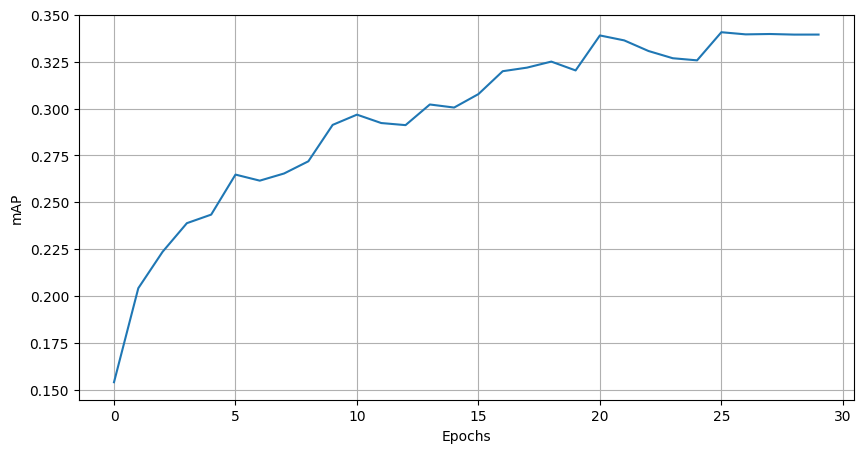

In [42]:
plt.figure(figsize=(10, 5))
plt.grid(True)
plt.xlabel("Epochs")
plt.ylabel("mAP")
plt.plot(evals);

In [29]:
conf_list = [0.0005, 0.001, 0.0015, 0.003, 0.01, 0.05]
iou_list = [0.45, 0.5, 0.55, 0.6, 0.63, 0.65, 0.7]

metric = MeanAveragePrecision(iou_type="bbox")
model_name = "/kaggle/input/faster_rcnn_model/pytorch/default/6/faster_rcnn_model.pth"

best_metric_value = 0
best_conf = -1
best_iou = -1

for conf_threshold in conf_list:
    for iou_threshold in iou_list:
        model = fasterrcnn_resnet50_fpn_v2(
            box_score_thresh=conf_threshold,      
            box_nms_thresh=iou_threshold
        )
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        num_classes = 6
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        model.load_state_dict(torch.load(model_name, weights_only=True))
        model = model.to(device)

        model.eval()
        metric.reset()
        with torch.no_grad():
            for images, targets in tqdm(test_loader, desc=f"Testing conf={conf_threshold}, iou={iou_threshold}"):
                images = list(image.to(device) for image in images)
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
                preds = model(images)
                metric.update(preds, targets)
        eval_metric = metric.compute()

        current_metric_value = eval_metric['map_50'].item() 
        print(f"conf={conf_threshold:.4f}, iou={iou_threshold:.4f} | mAP = {current_metric_value:.4f}")

        if current_metric_value > best_metric_value:
            best_metric_value = current_metric_value
            best_conf = conf_threshold
            best_iou = iou_threshold

print("\n" + "==="*15)
print(f"Оптимальные параметры: conf={best_conf:.3f}, iou={best_iou:.3f}")
print(f"Лучшее значение mAP_50: {best_metric_value:.4f}")

Testing conf=0.0005, iou=0.45: 100%|██████████| 613/613 [01:12<00:00,  8.45it/s]


conf=0.0005, iou=0.4500 | mAP = 0.7028


Testing conf=0.0005, iou=0.5: 100%|██████████| 613/613 [01:11<00:00,  8.59it/s]


conf=0.0005, iou=0.5000 | mAP = 0.7019


Testing conf=0.0005, iou=0.55: 100%|██████████| 613/613 [01:11<00:00,  8.59it/s]


conf=0.0005, iou=0.5500 | mAP = 0.6988


Testing conf=0.0005, iou=0.6: 100%|██████████| 613/613 [01:11<00:00,  8.57it/s]


conf=0.0005, iou=0.6000 | mAP = 0.6923


Testing conf=0.0005, iou=0.63: 100%|██████████| 613/613 [01:11<00:00,  8.52it/s]


conf=0.0005, iou=0.6300 | mAP = 0.6878


Testing conf=0.0005, iou=0.65: 100%|██████████| 613/613 [01:11<00:00,  8.53it/s]


conf=0.0005, iou=0.6500 | mAP = 0.6833


Testing conf=0.0005, iou=0.7: 100%|██████████| 613/613 [01:11<00:00,  8.57it/s]


conf=0.0005, iou=0.7000 | mAP = 0.6627


Testing conf=0.001, iou=0.45: 100%|██████████| 613/613 [01:11<00:00,  8.57it/s]


conf=0.0010, iou=0.4500 | mAP = 0.7028


Testing conf=0.001, iou=0.5: 100%|██████████| 613/613 [01:11<00:00,  8.53it/s]


conf=0.0010, iou=0.5000 | mAP = 0.7018


Testing conf=0.001, iou=0.55: 100%|██████████| 613/613 [01:11<00:00,  8.52it/s]


conf=0.0010, iou=0.5500 | mAP = 0.6988


Testing conf=0.001, iou=0.6: 100%|██████████| 613/613 [01:11<00:00,  8.53it/s]


conf=0.0010, iou=0.6000 | mAP = 0.6923


Testing conf=0.001, iou=0.63: 100%|██████████| 613/613 [01:11<00:00,  8.53it/s]


conf=0.0010, iou=0.6300 | mAP = 0.6877


Testing conf=0.001, iou=0.65: 100%|██████████| 613/613 [01:11<00:00,  8.54it/s]


conf=0.0010, iou=0.6500 | mAP = 0.6832


Testing conf=0.001, iou=0.7: 100%|██████████| 613/613 [01:11<00:00,  8.53it/s]


conf=0.0010, iou=0.7000 | mAP = 0.6626


Testing conf=0.0015, iou=0.45: 100%|██████████| 613/613 [01:11<00:00,  8.55it/s]


conf=0.0015, iou=0.4500 | mAP = 0.7027


Testing conf=0.0015, iou=0.5: 100%|██████████| 613/613 [01:11<00:00,  8.56it/s]


conf=0.0015, iou=0.5000 | mAP = 0.7018


Testing conf=0.0015, iou=0.55: 100%|██████████| 613/613 [01:11<00:00,  8.54it/s]


conf=0.0015, iou=0.5500 | mAP = 0.6988


Testing conf=0.0015, iou=0.6: 100%|██████████| 613/613 [01:11<00:00,  8.52it/s]


conf=0.0015, iou=0.6000 | mAP = 0.6923


Testing conf=0.0015, iou=0.63: 100%|██████████| 613/613 [01:11<00:00,  8.54it/s]


conf=0.0015, iou=0.6300 | mAP = 0.6877


Testing conf=0.0015, iou=0.65: 100%|██████████| 613/613 [01:11<00:00,  8.53it/s]


conf=0.0015, iou=0.6500 | mAP = 0.6832


Testing conf=0.0015, iou=0.7: 100%|██████████| 613/613 [01:11<00:00,  8.55it/s]


conf=0.0015, iou=0.7000 | mAP = 0.6626


Testing conf=0.003, iou=0.45: 100%|██████████| 613/613 [01:12<00:00,  8.50it/s]


conf=0.0030, iou=0.4500 | mAP = 0.7027


Testing conf=0.003, iou=0.5: 100%|██████████| 613/613 [01:12<00:00,  8.50it/s]


conf=0.0030, iou=0.5000 | mAP = 0.7017


Testing conf=0.003, iou=0.55: 100%|██████████| 613/613 [01:12<00:00,  8.51it/s]


conf=0.0030, iou=0.5500 | mAP = 0.6987


Testing conf=0.003, iou=0.6: 100%|██████████| 613/613 [01:12<00:00,  8.49it/s]


conf=0.0030, iou=0.6000 | mAP = 0.6921


Testing conf=0.003, iou=0.63: 100%|██████████| 613/613 [01:12<00:00,  8.49it/s]


conf=0.0030, iou=0.6300 | mAP = 0.6876


Testing conf=0.003, iou=0.65: 100%|██████████| 613/613 [01:12<00:00,  8.51it/s]


conf=0.0030, iou=0.6500 | mAP = 0.6832


Testing conf=0.003, iou=0.7: 100%|██████████| 613/613 [01:12<00:00,  8.49it/s]


conf=0.0030, iou=0.7000 | mAP = 0.6626


Testing conf=0.01, iou=0.45: 100%|██████████| 613/613 [01:12<00:00,  8.45it/s]


conf=0.0100, iou=0.4500 | mAP = 0.7018


Testing conf=0.01, iou=0.5: 100%|██████████| 613/613 [01:12<00:00,  8.50it/s]


conf=0.0100, iou=0.5000 | mAP = 0.7013


Testing conf=0.01, iou=0.55: 100%|██████████| 613/613 [01:11<00:00,  8.53it/s]


conf=0.0100, iou=0.5500 | mAP = 0.6982


Testing conf=0.01, iou=0.6: 100%|██████████| 613/613 [01:12<00:00,  8.50it/s]


conf=0.0100, iou=0.6000 | mAP = 0.6918


Testing conf=0.01, iou=0.63: 100%|██████████| 613/613 [01:12<00:00,  8.51it/s]


conf=0.0100, iou=0.6300 | mAP = 0.6872


Testing conf=0.01, iou=0.65: 100%|██████████| 613/613 [01:11<00:00,  8.53it/s]


conf=0.0100, iou=0.6500 | mAP = 0.6829


Testing conf=0.01, iou=0.7: 100%|██████████| 613/613 [01:11<00:00,  8.52it/s]


conf=0.0100, iou=0.7000 | mAP = 0.6624


Testing conf=0.05, iou=0.45: 100%|██████████| 613/613 [01:11<00:00,  8.54it/s]


conf=0.0500, iou=0.4500 | mAP = 0.6969


Testing conf=0.05, iou=0.5: 100%|██████████| 613/613 [01:11<00:00,  8.54it/s]


conf=0.0500, iou=0.5000 | mAP = 0.6961


Testing conf=0.05, iou=0.55: 100%|██████████| 613/613 [01:11<00:00,  8.53it/s]


conf=0.0500, iou=0.5500 | mAP = 0.6949


Testing conf=0.05, iou=0.6: 100%|██████████| 613/613 [01:11<00:00,  8.54it/s]


conf=0.0500, iou=0.6000 | mAP = 0.6889


Testing conf=0.05, iou=0.63: 100%|██████████| 613/613 [01:11<00:00,  8.52it/s]


conf=0.0500, iou=0.6300 | mAP = 0.6845


Testing conf=0.05, iou=0.65: 100%|██████████| 613/613 [01:11<00:00,  8.54it/s]


conf=0.0500, iou=0.6500 | mAP = 0.6804


Testing conf=0.05, iou=0.7: 100%|██████████| 613/613 [01:11<00:00,  8.54it/s]


conf=0.0500, iou=0.7000 | mAP = 0.6608

Оптимальные параметры: conf=0.001, iou=0.450
Лучшее значение mAP_50: 0.7028


In [30]:
model = fasterrcnn_resnet50_fpn_v2(
    box_score_thresh=0.001,      
    box_nms_thresh=0.450
)
in_features = model.roi_heads.box_predictor.cls_score.in_features
num_classes = 6
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
model_name = "/kaggle/input/faster_rcnn_model/pytorch/default/6/faster_rcnn_model.pth"
model.load_state_dict(torch.load(model_name, weights_only=True))
model = model.to(device)

In [31]:
model.eval()
metric.reset()
with torch.no_grad():
    for images, targets in tqdm(test_loader):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        preds = model(images)
        metric.update(preds, targets)
eval_metric = metric.compute()
eval_metric

100%|██████████| 613/613 [01:11<00:00,  8.52it/s]


{'map': tensor(0.3414),
 'map_50': tensor(0.7028),
 'map_75': tensor(0.2773),
 'map_small': tensor(0.2650),
 'map_medium': tensor(0.2608),
 'map_large': tensor(0.4512),
 'mar_1': tensor(0.3084),
 'mar_10': tensor(0.5001),
 'mar_100': tensor(0.5125),
 'mar_small': tensor(0.3735),
 'mar_medium': tensor(0.4530),
 'mar_large': tensor(0.6000),
 'map_per_class': tensor(-1.),
 'mar_100_per_class': tensor(-1.),
 'classes': tensor([1, 2, 3, 4, 5], dtype=torch.int32)}

# Лучшие метрики качества: `mAP[.5]=0.7028`, `mAP[.5:.95]=0.3414`

In [61]:
show_transforms = A.Compose([
    A.Resize(800, 1600, interpolation=cv2.INTER_LANCZOS4, p=1.0),
    A.Normalize(),
    A.ToTensorV2()]
)

## Оценка скорости инференса модели на `CPU` и `GPU`

In [60]:
device = "cuda"
model = model.to(device)

In [62]:
image_path = "dataset/images/val/2_img0106.png"
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_tensor = show_transforms(image=image)["image"].to(device)

In [63]:
%%time
model.eval()
with torch.no_grad():
    predictions = model([img_tensor])[0]

CPU times: user 115 ms, sys: 0 ns, total: 115 ms
Wall time: 114 ms


In [66]:
device = "cpu"
model = model.to(device)
img_tensor = img_tensor.to(device)

In [67]:
%%time
model.eval()
with torch.no_grad():
    predictions = model([img_tensor])[0]

CPU times: user 6.88 s, sys: 2.17 s, total: 9.05 s
Wall time: 4.61 s


In [41]:
def show_image_bbox(model, image_path, figsize=(15, 8), score_threshold=0.75):
    model.eval()
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_tensor = show_transforms(image=image)["image"].to(device)
    with torch.no_grad():
        predictions = model([img_tensor])[0]
    boxes = predictions['boxes'].cpu().numpy()
    H_orig, W_orig, _ = image.shape 
    H_resized, W_resized = 800, 1600
 
    scale_w = W_orig / W_resized
    scale_h = H_orig / H_resized
    
    scaled_boxes = boxes.copy()
    scaled_boxes[:, 0] = boxes[:, 0] * scale_w  # xmin
    scaled_boxes[:, 2] = boxes[:, 2] * scale_w  # xmax
    scaled_boxes[:, 1] = boxes[:, 1] * scale_h  # ymin
    scaled_boxes[:, 3] = boxes[:, 3] * scale_h  # ymax

    plt.figure(figsize=figsize)
    plt.imshow(image);
    for box, score, label in zip(scaled_boxes, predictions["scores"], predictions["labels"]):
        if score > score_threshold:
            bbox(box, label.item())

# Предсказания лучшей модели

In [65]:
image_path = "dataset/images/val/2_img0106.png"

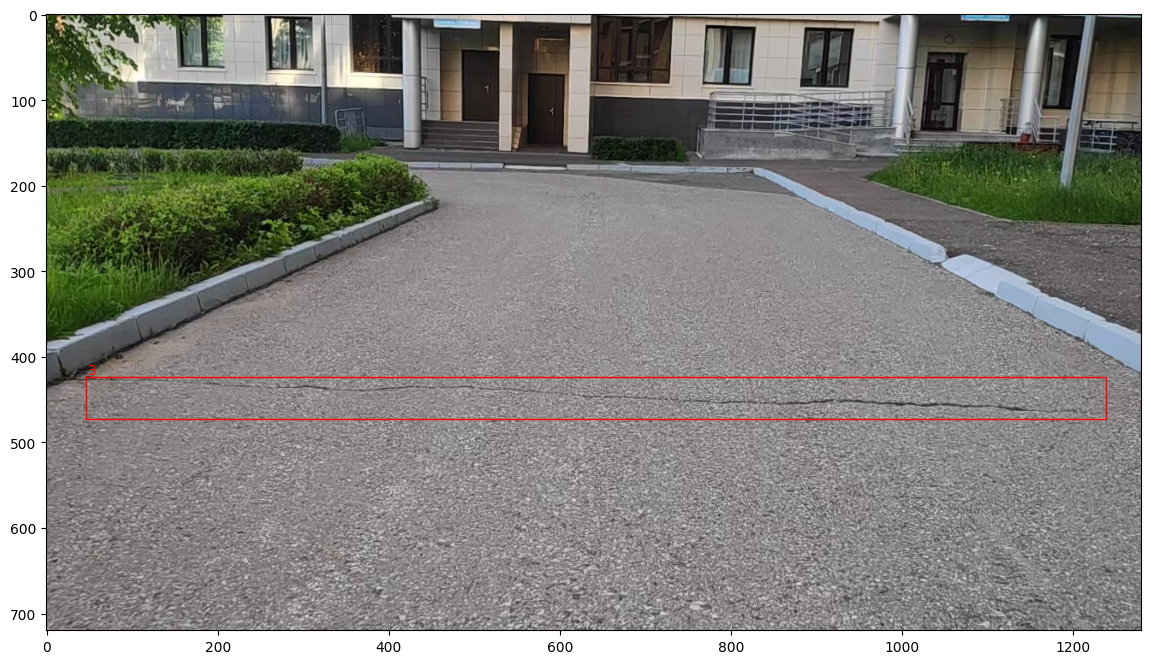

In [66]:
show_image_bbox(model, image_path)

In [67]:
image_path = "dataset/images/val/5_img0004.png"

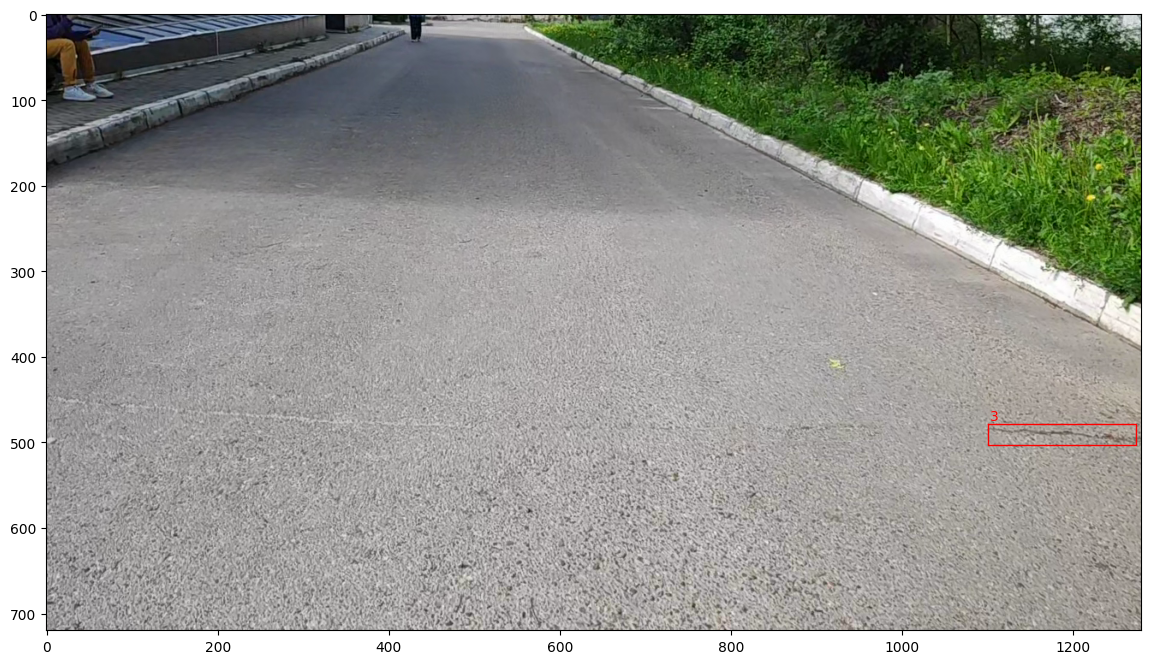

In [68]:
show_image_bbox(model, image_path)

In [69]:
image_path = "dataset/images/val/4_img0045.png"

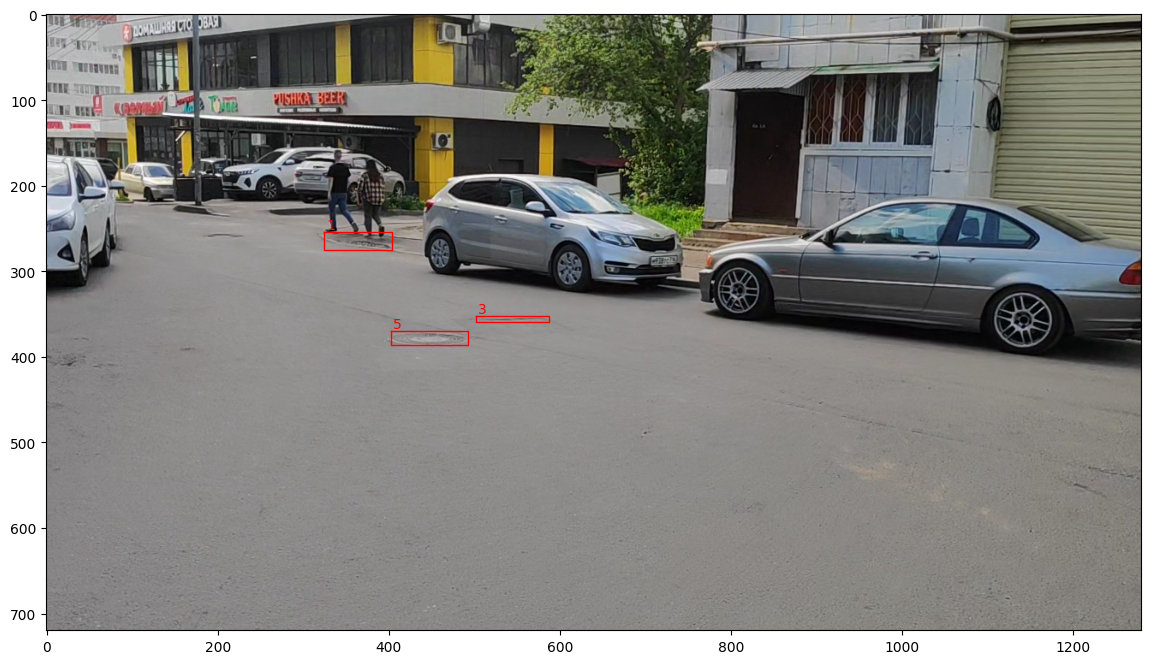

In [70]:
show_image_bbox(model, image_path)

In [75]:
image_path = "dataset/images/val/3_img0001.png"

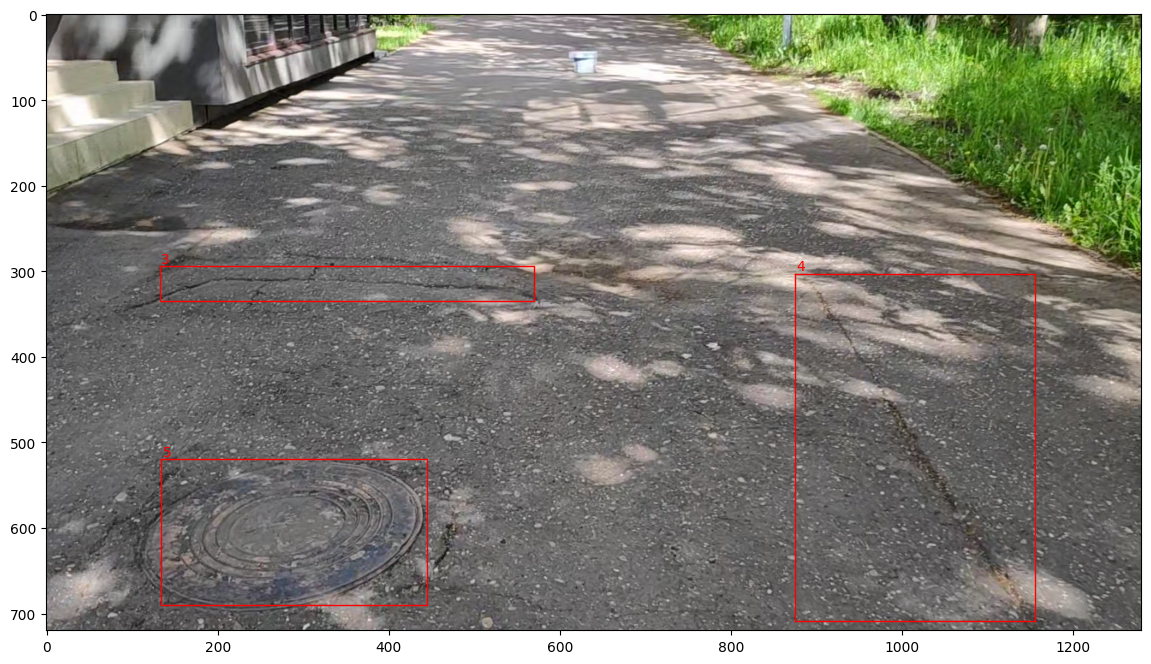

In [76]:
show_image_bbox(model, image_path)